In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = ("PCI_BUS_ID")
os.environ["CUDA_VISIBLE_DEVICES"] = '0,1,2,3,4'

In [2]:
import torch
import keras
import pytorch2keras
import tensorflow as tf
torch.cuda.empty_cache()
import pandas as pd
import numpy as np
import math
import csv
from numpy import ndarray
from torch.utils import data
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tqdm.notebook as tqdm
import time
from torch.autograd import Variable
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.utils.data import Dataset
from torch.optim import Adam, SGD
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, models, transforms
from visdom import Visdom


Using TensorFlow backend.


In [3]:
def load_data(storage_folder):
    x_data = None
    y_data = None
    
    # decide which data to load    
    data_file = '_fft_x_save.npz'
    data_path = os.path.join(storage_folder, data_file)
    x_data = np.load(data_path)
    
    data_file = '_fft_y_save.npz'
    data_path = os.path.join(storage_folder, data_file)
    y_data = np.load(data_path)    
    
    return x_data,y_data

def split_data(x_data, y_data, validation_fraction):
    """
    Splits the data into training and validation data
    according to the fraction that was specified. The samples are shuffled and then selected.
    The data is equally splitted along classes and signal to noise ratios.
    The new data array, validation array and the according label arrays are returned.
    """
    # Shuffle data
    x_data, y_data = shuffle_in_unison(x_data, y_data)
    # Split data
    nb_sets = x_data.shape[1]
    nb_cutted = int(np.floor(nb_sets * validation_fraction))
    x_test = x_data[::,-1:(-nb_cutted-1):-1,::,::]
    y_test = y_data[::,-1:(-nb_cutted-1):-1]
    x_data = np.delete(x_data, np.s_[-1:(-nb_cutted-1):-1], axis=1)
    y_data = np.delete(y_data, np.s_[-1:(-nb_cutted-1):-1], axis=1)
    return x_data, y_data, x_test, y_test

def normalize_data(x_train, x_test):
    """
    $x_train and $x_test are numpy arrays which should be normalized.
    Normalizes the training data to have a train_mean of 0 and a standard deviation of 1. 
    The test data is normalized with the parameters of the training data
    Returns the normalized data in the same format as given.
    """
    train_mean_1 = np.mean(x_train[:,:,:,0])
    train_mean_2 = np.mean(x_train[:,:,:,1])

    train_std_dev_1 = np.std(x_train[:,:,:,0])
    train_std_dev_2 = np.std(x_train[:,:,:,1])

    x_train[:,:,:,0] = (x_train[:,:,:,0] - train_mean_1) / train_std_dev_1 # element-wise operations
    x_train[:,:,:,1] = (x_train[:,:,:,1] - train_mean_2) / train_std_dev_2 # element-wise operations
    
    x_test[:,:,:,0] = (x_test[:,:,:,0] - train_mean_1) / train_std_dev_1 # element-wise operations
    x_test[:,:,:,1] = (x_test[:,:,:,1] - train_mean_2) / train_std_dev_2 # element-wise operations

    return x_train, x_test

def shuffle_in_unison(x_data, y_data, seed=159739):
    '''
    This method shuffles the data of the Data Set axis of the test and training data.
    It is inspired by http://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    '''
    np.random.seed(seed)
    shuffled_x = np.empty(x_data.shape, dtype=x_data.dtype)
    shuffled_y = np.empty(y_data.shape, dtype=y_data.dtype)
    permutation = np.random.permutation(x_data.shape[1])  #snapshots number row
    for old_index, new_index in enumerate(permutation):
        shuffled_x[::,new_index,::,::] = x_data[::,old_index,::,::]
        shuffled_y[::,new_index] = y_data[::,old_index]
    return shuffled_x, shuffled_y

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    df_cm = pd.DataFrame(cm, labels, labels)
    plt.figure(figsize=(6,5))
    plt.title(title)
    sn.heatmap(df_cm, center=0, cmap=plt.cm.Blues, annot=True, fmt='.2f')

In [4]:
class IteratorTimer():
    def __init__(self, iterable):
        self.iterable = iterable
        self.iterator = self.iterable.__iter__()
        

    def __iter__(self):
        return self

    def __len__(self):
        return len(self.iterable)

    def __next__(self):
        start = time.time()
        n = self.iterator.next()
        self.last_duration = (time.time() - start)
        return n

    next = __next__

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=(3, 1))
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 2))

        self.linear1 = nn.Linear(256*124, 1024)
        self.linear2 = nn.Linear(1024,2)

        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.4)
        self.softmax = nn.Softmax(dim=1)
    def forward(self, input):

        output = self.conv1(input)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.conv2(output)
        output = self.relu(output)
        output = self.dropout(output)

        output = output.view(-1, 256*124)
        
        output = self.linear1(output)
        output = self.relu(output)
        output = self.dropout(output)
        
        output = self.linear2(output)
        output = self.softmax(output)

        
        return output


In [6]:
# prepare the data for cnn

folder = '/path/to/iq_data/folder/'

x, y = load_data(folder)

x.files
y.files

x_data = x['arr_0']
y_data = y['arr_0']

#print(x_data,y_data)

x_train, y_train, x_test, y_test = split_data(x_data, y_data, 0.4)
x_train, x_test = normalize_data(x_train, x_test)
if x_test.strides[1] < 0:
    x_test = np.flip(x_test, axis=1)
if y_test.strides[1] < 0:
    y_test = np.flip(y_test, axis=1)

x_train = np.float64(x_train)
x_test = np.float64(x_test) 
x_train = torch.from_numpy(x_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.long)
x_test = torch.from_numpy(x_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.long)

#for training
x_train_training = x_train.contiguous().view(2*2398, 1, 128, 2)
y_train_training = y_train.contiguous().view(2*2398)
x_test_training = x_test.contiguous().view(2*1598, 1, 128, 2)
y_test_training = y_test.contiguous().view(2*1598) 

x_test_plot = x_test.contiguous().view(2, 1598, 1, 1, 128, 2)
y_test_plot = y_test

x_test_confusion = x_test.contiguous().view(2, 1598, 1, 128, 2)

In [7]:
dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            dataset=data.TensorDataset(x_train_training, y_train_training),
            batch_size=256,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            data.TensorDataset(x_test_training, y_test_training),
            batch_size=256,
            shuffle=False,
            num_workers=4)}

In [8]:
device = torch.device("cuda:0,1,2,3,4")

model = torch.load('/path/to/pretrained_model/cnn_entire_model.h5')

num_classes = 2

model.to(device)

for name,param in model.named_parameters():
    if name in ['linear1.weight', 'linear1.bias','linear2.weight','linear2.bias']:
        param.requires_grad = True
    else:
        param.requires_grad = False

num_ftrs = model.linear2.in_features
model.linear2 = nn.Linear(num_ftrs, num_classes)

model.linear2.to(device)

for name,param in model.named_parameters():
    print("name: ", name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ',param.requires_grad)
    print('weight: ', torch.sum(param))
    print('=====')
    
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00001)

name:  conv1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([256, 1, 3, 1])
param.requires_grad:  False
weight:  tensor(3.5419, device='cuda:0')
=====
name:  conv1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([256])
param.requires_grad:  False
weight:  tensor(3.1674, device='cuda:0')
=====
name:  conv2.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([256, 256, 3, 2])
param.requires_grad:  False
weight:  tensor(6911.1113, device='cuda:0')
=====
name:  conv2.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([256])
param.requires_grad:  False
weight:  tensor(-2.4103, device='cuda:0')
=====
name:  linear1.weight
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([1024, 31744])
param.requires_grad:  True
weight:  tensor(-18169.9824, device='cuda:0', grad_fn=<SumBackward0>)
=====
name:  linear1.bias
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([1024])
param.requires_grad:

In [10]:
def train_model(model, criterion, optimizer, num_epochs=21):
    
    best_val_accuracy = 0
    best_val_loss = 100
    t_epoch_accuracy = []
    v_epoch_accuracy = []
    epoch_n = 0
    t_e_loss = []
    v_e_loss = []
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    outputs.to(device)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #print("Loss at first step: ",loss)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                epoch_loss = running_loss / (2*2398)
                epoch_acc = running_corrects.double() / (2*2398)
                t_e_loss.append(epoch_loss)
                t_epoch_accuracy.append(epoch_acc)

            else:
                epoch_loss = running_loss / (2*1598)
                epoch_acc = running_corrects.double() / (2*1598)
                v_e_loss.append(epoch_loss)
                v_epoch_accuracy.append(epoch_acc)
                
            
            if (phase == 'validation' and epoch_acc > best_val_accuracy):
                best_val_accuracy = epoch_acc
                torch.save(model,'/path/to/recording_weight/TL_fft.pth')

                
            if (phase == 'validation' and epoch_loss < best_val_loss):
                best_val_loss = epoch_loss
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            if phase == 'validation':
                print('Best acc: {:.4f}'.format(best_val_accuracy))
                            
    return model, t_epoch_accuracy, t_e_loss, v_epoch_accuracy, v_e_loss

In [11]:
#rerunning the 21 epoches for visualizing result
model_trained, t_acc, t_loss, v_acc, v_loss = train_model(model, criterion, optimizer, num_epochs=21)
model = torch.load('/path/to/recording/weight/TL_fft_iq.pth')

Epoch 1/21
----------
train loss: 0.6043, acc: 0.7129
validation loss: 0.4643, acc: 0.8470
Best acc: 0.8470
Epoch 2/21
----------


/home/thida/anaconda3/envs/wii-cnn/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train loss: 0.4896, acc: 0.8330
validation loss: 0.4035, acc: 0.9208
Best acc: 0.9208
Epoch 3/21
----------
train loss: 0.4390, acc: 0.8830
validation loss: 0.3789, acc: 0.9446
Best acc: 0.9446
Epoch 4/21
----------
train loss: 0.4062, acc: 0.9172
validation loss: 0.3700, acc: 0.9496
Best acc: 0.9496
Epoch 5/21
----------
train loss: 0.3975, acc: 0.9226
validation loss: 0.3653, acc: 0.9528
Best acc: 0.9528
Epoch 6/21
----------
train loss: 0.3874, acc: 0.9322
validation loss: 0.3623, acc: 0.9540
Best acc: 0.9540
Epoch 7/21
----------
train loss: 0.3829, acc: 0.9354
validation loss: 0.3605, acc: 0.9543
Best acc: 0.9543
Epoch 8/21
----------
train loss: 0.3763, acc: 0.9412
validation loss: 0.3594, acc: 0.9553
Best acc: 0.9553
Epoch 9/21
----------
train loss: 0.3717, acc: 0.9454
validation loss: 0.3586, acc: 0.9565
Best acc: 0.9565
Epoch 10/21
----------
train loss: 0.3729, acc: 0.9437
validation loss: 0.3579, acc: 0.9565
Best acc: 0.9565
Epoch 11/21
----------
train loss: 0.3697, acc: 0

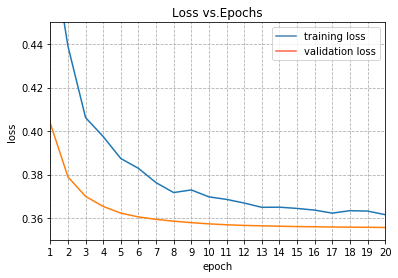

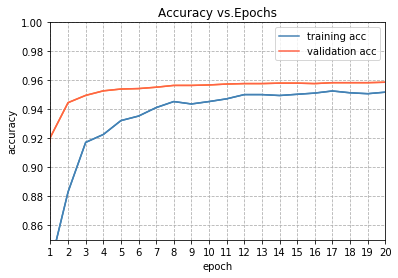

In [20]:
import matplotlib.pyplot as plt

plt.title("Loss vs.Epochs")
plt.xlim([1, 20])
plt.ylim([0.35, 0.45])
#plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(linestyle='--')

plt.plot(t_loss)
plt.plot(v_loss)
line_up, = plt.plot(t_acc, label='training loss', color = 'steelblue')
line_down, = plt.plot(v_acc, label='validation loss',  color = 'tomato')
plt.legend(handles=[line_up, line_down], loc = 'upper right')
plt.savefig("TL_fft_loss")
plt.show()

plt.title("Accuracy vs.Epochs")
plt.xlim([1, 20])
plt.ylim([0.85, 1])
#plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(linestyle='--')

plt.plot(t_acc)
plt.plot(v_acc)
line_up, = plt.plot(t_acc, label='training acc', color = 'steelblue')
line_down, = plt.plot(v_acc, label='validation acc',  color = 'tomato')
plt.legend(handles=[line_up, line_down], loc = 'upper right')
plt.savefig("TL_fft_acc")
plt.show()


In [13]:
accuracy_wifi = 0
accuracy_bluetooth = 0

model.eval()
with torch.no_grad():
    target = y_test_plot[0].contiguous().view(1598)
    input = x_test_plot[0].cuda().contiguous().view(1598, 1, 128, 2)
    output = model(input).argmax(dim=1).cpu()
    num_correct = torch.eq(output, target).sum().item()
    accuracy_wifi = num_correct / (1598)
    
    target = y_test_plot[1].contiguous().view(1598)
    input = x_test_plot[1].cuda().contiguous().view(1598, 1, 128, 2)
    output = model(input).argmax(dim=1).cpu()
    num_correct = torch.eq(output, target).sum().item()
    accuracy_bluetooth = num_correct / (1598)

print(accuracy_wifi)
print(accuracy_bluetooth)

0.9180225281602002
0.983729662077597


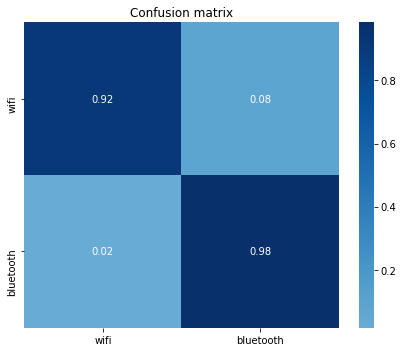

In [14]:
# plot confusion matrix for all SNR
classes = ['wifi',
           'bluetooth']
confusion_matrix = np.zeros((2,2))
confusion_matrix_norm = np.zeros((2,2))
model.to(device)
model.eval()
with torch.no_grad():
    for i in range(2):
        input = x_test_confusion[i].cuda()
        output= model(input).argmax(dim=1).cpu()
        confusion_matrix[i] = output.bincount()
    
confusion_matrix_norm = confusion_matrix / (1598)
confusion_matrix_norm = (confusion_matrix_norm > 0.01) * confusion_matrix_norm

plot_confusion_matrix(confusion_matrix_norm, labels=classes)
plt.tight_layout()
plt.savefig("TL_fft_confusion_matrix")

In [15]:
model1 = torch.load('/path/to/TL_fft.pth')

for name, param in model1.named_parameters():
    print(name, ':', param.requires_grad)
    print('weight: ', torch.sum(param))    

conv1.weight : False
weight:  tensor(3.5419, device='cuda:0')
conv1.bias : False
weight:  tensor(3.1674, device='cuda:0')
conv2.weight : False
weight:  tensor(6911.1113, device='cuda:0')
conv2.bias : False
weight:  tensor(-2.4103, device='cuda:0')
linear1.weight : True
weight:  tensor(-17243.1934, device='cuda:0', grad_fn=<SumBackward0>)
linear1.bias : True
weight:  tensor(4.2877, device='cuda:0', grad_fn=<SumBackward0>)
linear2.weight : True
weight:  tensor(-0.1977, device='cuda:0', grad_fn=<SumBackward0>)
linear2.bias : True
weight:  tensor(-0.0221, device='cuda:0', grad_fn=<SumBackward0>)


In [16]:
scratch_model = CNN()
scratch_model = torch.load('/path/to/non_TL/entire_RF_fft.pth')

num_ftrs = scratch_model.linear2.in_features
model.linear2 = nn.Linear(num_ftrs, 2)

scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.00001)
scratch_criterion = nn.CrossEntropyLoss()
scratch_hist = train_model(scratch_model, scratch_criterion, scratch_optimizer, num_epochs=21)
s_model, s_t_acc, s_t_loss, s_v_acc, s_v_loss = train_model(scratch_model, scratch_criterion, scratch_optimizer, num_epochs=20)


Epoch 1/21
----------
train loss: 0.3614, acc: 0.9518
validation loss: 0.4101, acc: 0.8955
Best acc: 0.8955
Epoch 2/21
----------


/home/thida/anaconda3/envs/wii-cnn/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


train loss: 0.3609, acc: 0.9518
validation loss: 0.3740, acc: 0.9437
Best acc: 0.9437
Epoch 3/21
----------
train loss: 0.3606, acc: 0.9527
validation loss: 0.4288, acc: 0.8717
Best acc: 0.9437
Epoch 4/21
----------
train loss: 0.3612, acc: 0.9518
validation loss: 0.4209, acc: 0.8808
Best acc: 0.9437
Epoch 5/21
----------
train loss: 0.3609, acc: 0.9516
validation loss: 0.3857, acc: 0.9315
Best acc: 0.9437
Epoch 6/21
----------
train loss: 0.3608, acc: 0.9525
validation loss: 0.3667, acc: 0.9496
Best acc: 0.9496
Epoch 7/21
----------
train loss: 0.3609, acc: 0.9525
validation loss: 0.3717, acc: 0.9456
Best acc: 0.9496
Epoch 8/21
----------
train loss: 0.3609, acc: 0.9523
validation loss: 0.3789, acc: 0.9393
Best acc: 0.9496
Epoch 9/21
----------
train loss: 0.3602, acc: 0.9533
validation loss: 0.3747, acc: 0.9412
Best acc: 0.9496
Epoch 10/21
----------
train loss: 0.3605, acc: 0.9525
validation loss: 0.3967, acc: 0.9143
Best acc: 0.9496
Epoch 11/21
----------
train loss: 0.3602, acc: 0

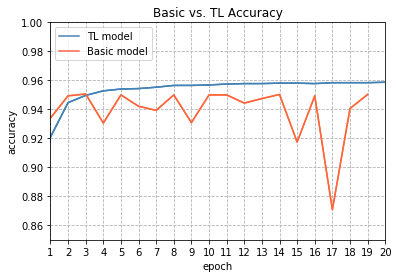

In [19]:
import matplotlib.pyplot as plt
plt.title("Basic vs. TL Accuracy")
plt.xlim([1, 20])
plt.ylim([0.85, 1])
#plt.yticks(np.linspace(0, 1, 11))
plt.xticks(np.linspace(1, 20, 20))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(linestyle='--')

plt.plot(v_acc)
plt.plot(s_v_acc)
line_up, = plt.plot(v_acc, label='TL model', color = 'steelblue')
line_down, = plt.plot(s_v_acc, label='Basic model',  color = 'tomato')
plt.legend(handles=[line_up, line_down], loc = 'upper left')
plt.savefig("TL_basic_fft_acc")
plt.show()